<a href="https://colab.research.google.com/github/akalpit23/Explainable-techniques/blob/main/Explainable_Techniques_Assignment_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #05



## Akalpit Dawkhar

### **Explainable Techniques**

### Overview

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Explainable-techniques" # Change to your repo name
git_path = 'https://github.com/akalpit23/Explainable-techniques.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Explainable_Techniques_Assignment_05.ipynb'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls


rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'Explainable-techniques' already exists and is not an empty directory.
[Errno 20] Not a directory: 'Explainable-techniques/Explainable_Techniques_Assignment_05.ipynb'
/content
Explainable-techniques/


In [8]:
import pandas as pd
import numpy as np
import torch
import xgboost as xgb
import shap
import lime
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from lime import lime_image
from sklearn.model_selection import train_test_split
from anchor import anchor_tabular
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import accuracy_score, classification_report
from skimage.segmentation import mark_boundaries
from tensorflow.keras.datasets import cifar10
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from PIL import Image
from skimage.segmentation import mark_boundaries

In [3]:
# Load pre-trained ResNet34 model
model = models.resnet34(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 84.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# 3. Define image preprocessing steps (resize, normalize)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# 4. Load and preprocess the image
image_path = '/content/Explainable-techniques/Keyboard.jpg'
img = Image.open(image_path)
img_tensor = preprocess(img).unsqueeze(0)

# 5. Predict with the model
output = model(img_tensor)
_, pred_class = torch.max(output, 1)


  0%|          | 0/10 [00:00<?, ?it/s]

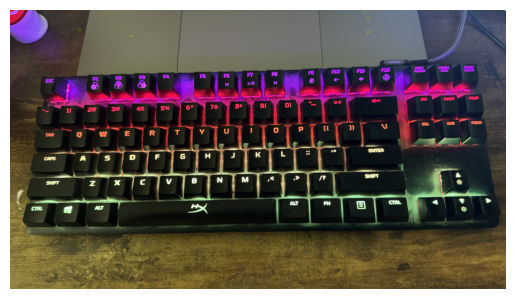

In [6]:
# 6. Define the LIME explainer
explainer = lime_image.LimeImageExplainer()

# 7. Function to predict the output of perturbed images for LIME
def predict_fn(images):
    batch = torch.stack([preprocess(Image.fromarray(img)) for img in images])
    output = model(batch)
    return output.detach().numpy()

# 8. Generate explanations for the prediction
explanation = explainer.explain_instance(np.array(img), predict_fn, top_labels=1, hide_color=0, num_samples=10)

# 9. Visualize the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.show()

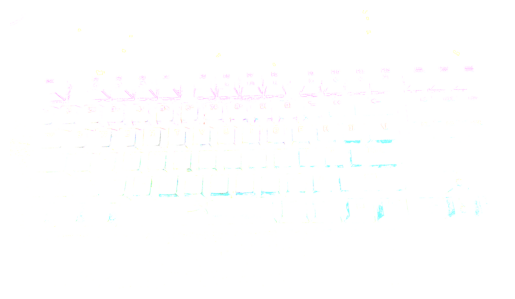

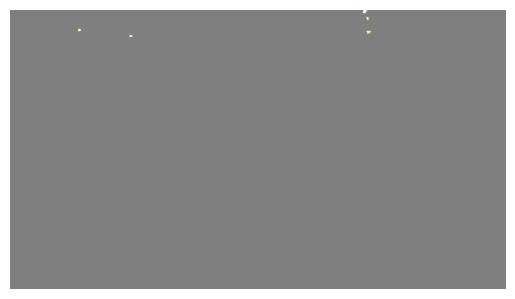

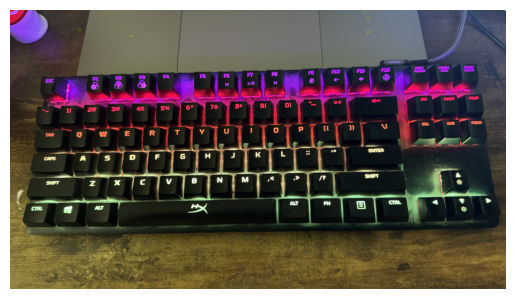

In [10]:
# 9. Visualize the explanation

# Get the top predicted label from the explanation
top_label = explanation.top_labels[0]

# First visualization: Show explanation with positive_only=False, num_features=10, hide_rest=False
temp, mask = explanation.get_image_and_mask(top_label, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))  # Visualize the mask on the image
plt.axis('off')
plt.show()

# Second visualization: Show explanation with positive_only=True, num_features=5, hide_rest=True
temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))  # Visualize the mask on the image
plt.axis('off')
plt.show()

# Original visualization: Show explanation with positive_only=True, num_features=5, hide_rest=False
temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 255.0, mask))  # Visualize the mask on the image
plt.axis('off')
plt.show()